In [1]:
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from collections import deque
import random as rand
import math
import matplotlib.pyplot as plt

In [2]:
import os
os.chdir('C:\\code\\activ')

In [3]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

np.set_printoptions(precision=6, suppress=True)

In [4]:
dnn_model = tf.keras.models.load_model('./model/dnn.h5')

In [5]:
EPS_START = 1.0
EPS_END = 0.01
EPS_DECAY = 100

GAMMA = 1.2
batch_size = 64
episode_done = 2000

In [6]:
df = pd.read_excel('./documents/aug_nine_var.xlsx').iloc[:,1:22]

scaler = MinMaxScaler()
X = scaler.fit_transform(df)

In [7]:
def return_latest():
    df = pd.read_excel('./documents/aug_nine_var.xlsx').iloc[:,1::]
    X = df.iloc[:,0:21]
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)
    latest = X[-1].reshape(1, 21)

    return latest

In [8]:
def return_state(action, state):
    if action % 2 == 0:
        var = -0.01
    
    else:
        var = 0.01

    j = int(action / 2)
    
    state[0][j] = state[0][j] + var
    next_state = state

    return next_state

In [9]:
def return_reward(state, y_pred):
    real_state = return_latest()

    dist = np.sqrt(np.sum(np.square(real_state-state)))

    a = tf.cast(tf.math.subtract(y_pred, 42), dtype=tf.float32)
    b = tf.cast(dist, dtype=tf.float32)

    loss = tf.math.add(a, b)
    return tf.math.multiply(loss, 100)

In [10]:
class Dqn_agent:
    def __init__(self):
        self.target = self._create_model()
        self.model = self._create_model()

        self.target.set_weights(self.model.get_weights())

        self.memory = deque(maxlen=10000)
        
    def _create_model(self):
        model = tf.keras.models.Sequential()
        model.add(tf.keras.layers.Dense(128, input_shape=(21, ), activation='relu'))
        model.add(tf.keras.layers.Dense(128, activation='relu'))
        model.add(tf.keras.layers.Dense(128, activation='relu'))
        model.add(tf.keras.layers.Dense(42, activation='linear'))

        optimizer = tf.keras.optimizers.Adam(learning_rate=0.00025, clipnorm=1.0)
        model.compile(optimizer=optimizer, loss='mse')

        return model

    def forward(self, x):
        x = self.model(x)
        return x
    
    def memorize(self, state, action, reward, next_state):
        self.memory.append((
            state, action,
            tf.cast(reward, tf.float16), next_state
        ))

    def act(self, state, episode):
        eps_threshold = EPS_END + ((EPS_START - EPS_END) * math.exp(-1 * episode / EPS_DECAY))
        if rand.random() > eps_threshold:
            return tf.convert_to_tensor([np.argmin(self.forward(state))]), eps_threshold
        else:
            return tf.convert_to_tensor([rand.randrange(42)]), eps_threshold

    def learn(self, episode):
        if len(self.memory) < batch_size:
            return

        batch = rand.sample(self.memory, batch_size)
        states, actions, rewards, next_states = zip(*batch)

        states = tf.convert_to_tensor(states).reshape(batch_size, 21) # (batch_size, 21)
        actions = tf.convert_to_tensor(actions) # (batch_size, )
        rewards = tf.convert_to_tensor(rewards).reshape(batch_size, 1) # (batch_size, )
        next_states = tf.convert_to_tensor(next_states).reshape(batch_size, 21) # (batch_size, 21)

        # print(f"s: {states.shape}, a: {actions.shape}, r: {rewards.shape}, ns: {next_states.shape}")

        current_q = self.model.predict(states, verbose=0)
        next_q = self.target.predict(next_states, verbose=0)

        # print(f"cq: {current_q.shape}, nq: {next_q.shape}")

        for i in range(batch_size):
            if episode == episode_done:
                next_q_value = rewards[i]
            else:
                next_q_value = rewards[i] + GAMMA * np.min(next_q[i])
            
            current_q[i][actions[i]] = next_q_value

        self.model.fit(states, current_q, batch_size=batch_size, verbose=False)
        return self.model.evaluate(states, current_q, batch_size=batch_size, verbose=0)
        

In [11]:
agent = Dqn_agent()
sc_hist = []
st_hist = []
pop_hist = []

for e in range(1, 1000):
    state = return_latest()
    steps = 0

    if e % 50 == 0:
        agent.target.set_weights(agent.model.get_weights())
    while True:
        pred_y = dnn_model.predict(state, verbose=0)

        action, eps = agent.act(state, e)

        next_state = return_state(action, state)
        reward = return_reward(state, pred_y)

        agent.memorize(state, action, reward, next_state)
        loss = agent.learn(e)

        state = next_state
        steps = steps + 1

        if steps % 100 == 0:
            print(f"steps: {steps}, reward: {reward[0][0]:.6f}, pop: {int(pred_y)}, loss: {loss:.4f}")

        if steps == episode_done:
            print("=============episode done=============")
            print(f"episode: {e}, reward: {reward}, y_pred: {pred_y}, eps: {eps}")
            print("=======================================")
            sc_hist.append(reward)
            st_hist.append(state)
            pop_hist.append(pred_y)
            break

steps: 100, reward: 276.320343, pop: 44, loss: 1583.5156
steps: 200, reward: 324.425110, pop: 45, loss: 1878.4954
steps: 300, reward: 336.979584, pop: 45, loss: 1485.7764
steps: 400, reward: 401.248688, pop: 45, loss: 504.1121
steps: 500, reward: 433.700500, pop: 46, loss: 63.2163
steps: 600, reward: 406.003418, pop: 45, loss: 77.6801
steps: 700, reward: 454.497681, pop: 46, loss: 87.3178
steps: 800, reward: 452.602142, pop: 46, loss: 115.9569
steps: 900, reward: 480.444672, pop: 46, loss: 111.1132
steps: 1000, reward: 491.117676, pop: 46, loss: 100.5212
steps: 1100, reward: 531.324097, pop: 46, loss: 108.9357
steps: 1200, reward: 520.989685, pop: 46, loss: 158.4533
steps: 1300, reward: 510.521637, pop: 46, loss: 154.0184
steps: 1400, reward: 503.492371, pop: 46, loss: 105.4743
steps: 1500, reward: 483.468719, pop: 46, loss: 198.8296
steps: 1600, reward: 512.606995, pop: 46, loss: 145.8158
steps: 1700, reward: 528.472961, pop: 46, loss: 158.3791
steps: 1800, reward: 573.705322, pop: 47

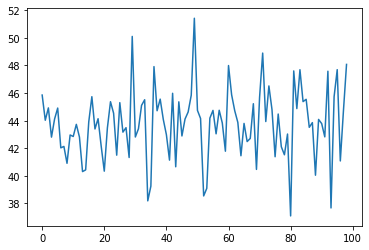

In [ ]:
plt.plot(np.array(pop_hist).reshape(99))
plt.show()

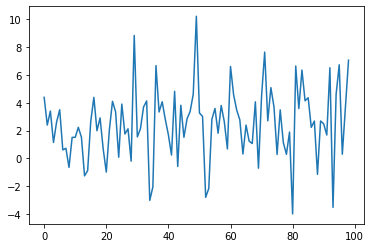

In [ ]:
plt.plot(np.array(sc_hist).reshape(99))
plt.show()

In [ ]:
np_st_hist = np.array(st_hist)

In [ ]:
np_st_hist.shape

(99, 1, 21)

In [ ]:
result = np.array(st_hist).reshape(99, 21)
X_result = scaler.inverse_transform(result)
pop_result = np.array(pop_hist).reshape(99, 1)

In [ ]:
df = np.append(X_result, pop_result, axis=1)

In [ ]:
pd_df = pd.DataFrame(df)
pd_df.to_excel('./documents/result/dqn.xlsx')